Markov state model for pentapeptide
=====

In this notebook we will give a brief overview of some of PyEMMA's capabilities by analyzing MD simulations of a Pentapeptide with Markov state models. We will demonstrate how to compute metastable states and visualize their structures, how to compute the equilibrium probabilities of and transition rates between metastable states, and how to compute transition pathways.

First we import pyemma and check what version we are using.

In [1]:
import pyemma
pyemma.__version__

'2.5'

This notebook has been tested for version 2.5. If you are using a different version some adaptations may be required.

Now we import a few general packages, including basic numerics and algebra routines (numpy) and plotting routines (matplotlib), and makes sure that all plots are shown inside the notebook rather than in a separate window (nicer that way).

In [3]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})

Now we import the PyEMMA modules required for the following steps.

In [4]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt

In [65]:
import warnings
def plot_sampled_function(xall, yall, zall, ax=None, nbins=100, nlevels=20, cmap=plt.cm.bwr, cbar=True, cbar_label=None):
    # histogram data
    xmin = np.min(xall)
    xmax = np.max(xall)
    dx = (xmax - xmin) / float(nbins)
    ymin = np.min(yall)
    ymax = np.max(yall)
    dy = (ymax - ymin) / float(nbins)
    # bin data
    eps = x
    xbins = np.linspace(xmin - 0.5*dx, xmax + 0.5*dx, num=nbins)
    ybins = np.linspace(ymin - 0.5*dy, ymax + 0.5*dy, num=nbins)
    xI = np.digitize(xall, xbins)
    yI = np.digitize(yall, ybins)
    # result
    z = np.zeros((nbins, nbins))
    N = np.zeros((nbins, nbins))
    # average over bins
    for t in range(len(xall)):
        z[xI[t], yI[t]] += zall[t]
        N[xI[t], yI[t]] += 1.0
    
    with warnings.catch_warnings() as cm:
        warnings.simplefilter('ignore')
        z /= N
    # do a contour plot
    extent = [xmin, xmax, ymin, ymax]
    if ax is None:
        ax = plt.gca()
    ax.contourf(z.T, 100, extent=extent, cmap=cmap)
    if cbar:
        cbar = plt.colorbar()
        if cbar_label is not None:
            cbar.ax.set_ylabel(cbar_label)
            
    return ax

In [9]:
def plot_sampled_density(xall, yall, zall, ax=None, nbins=100, cmap=plt.cm.Blues, cbar=True, cbar_label=None):
    return plot_sampled_function(xall, yall, zall, ax=ax, nbins=nbins, cmap=cmap, cbar=cbar, cbar_label=cbar_label)

Load pentapeptide coordinates and select features
------

We first have to load the PDB file and the trajectory data, in this case for WW-pentapeptide. They are stored on a FTP server and can easily be downloaded with mdshare. Please use `pip install mdshare` for installation.

In [43]:
from mdshare import load

In [80]:
topfile = load('pentapeptide-impl-solv.pdb')
traj_list = [load('pentapeptide-%02d-500ns-impl-solv.xtc' % i) for i in range(25)]

We can decide here which features we would like to use in the further analysis. In this case backbone torsions. As we want to do TICA on those coordinates, which requires subtracting the mean from each feature, we cannot use angles directly but have to transform them into a space where an arithmetic mean can be computed. We are using the cos/sin transform to do this, specified by the *cossin* option.

In [50]:
feat = coor.featurizer(topfile)
feat.add_backbone_torsions(cossin=True)
feat.add_sidechain_torsions(which=['chi1'], cossin=True)
#feat.add_distances(feat.pairs(feat.select_Heavy()))
# describe the features
# feat.describe()

In [51]:
feat.dimension()

24

Now we define the source of input coordinates (we don't load them into memory at this stage - they will be loaded as needed). Compute a few basic data statistics gives:

In [52]:
inp = coor.source(traj_list, feat)
print('number of trajectories = ',inp.number_of_trajectories())
print('trajectory length = ',inp.trajectory_length(0))
print('trajectory time step = ', 500.0 / (inp.trajectory_length(0)-1),'ns')
print('number of dimension = ',inp.dimension())

HBox(children=(HBox(children=(Label(value='Obtaining file info'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=25), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

number of trajectories =  25
trajectory length =  5001
trajectory time step =  0.1 ns
number of dimension =  24


TICA and clustering 
-----

For TICA we have to choose a *lag* time and we have to define the output dimension. This can be either set by the *dim* keyword, or by specify a percentage the kinetic variance we want to keep. Here we choose 90%, which gives us three dimensions. From the original 16-dimensional space, most of the relevant kinetic information is in a four-dimensional subspace.

In [53]:
tica_obj = coor.tica(inp, lag=20, var_cutoff=0.9, kinetic_map=True)
print('TICA dimension ', tica_obj.dimension())

HBox(children=(HBox(children=(Label(value='calculate covariances'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=25), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

TICA dimension  4


We can have a look at the cumulative kinetic variance, which is similar to the cumulative variance in PCA. Three dimensions explain 78% of the data, five dimensions 95%.

In [54]:
tica_obj.cumvar

array([ 0.28242444,  0.55556987,  0.77854208,  0.91681177,  0.95379052,
        0.9775015 ,  0.99387717,  0.99867582,  0.99919043,  0.99933653,
        0.99946633,  0.9995863 ,  0.99969647,  0.99978577,  0.99984232,
        0.99988717,  0.99992192,  0.99994782,  0.99996789,  0.99998051,
        0.99999047,  0.99999834,  0.99999984,  1.        ])

In [18]:
# here we do a little trick to ensure that eigenvectors always have the same sign structure. 
# That's irrelevant to the analysis and just nicer plots - you can ignore it.
for i in range(2):
    if tica_obj.eigenvectors[0, i] > 0: 
        tica_obj.eigenvectors[:, i] *= -1

Now we get the TICA output, i.e. the coordinates after being transformed to the three slowest components. You can think of this as a low-dimensional space of good reaction coordinates. 
Having a look at the shape of the output reveals that we still have 25 trajectories, each of length 5001, but now only three dimensions.

In [19]:
Y = tica_obj.get_output() # get tica coordinates
print('number of trajectories = ', np.shape(Y)[0])
print('number of frames = ', np.shape(Y)[1])
print('number of dimensions = ',np.shape(Y)[2])

HBox(children=(HBox(children=(Label(value='getting output of TICA'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=25), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

number of trajectories =  25
number of frames =  5001
number of dimensions =  4


Note that at this point we loaded the compressed coordinates into memory. We don't have to do this, but it will significantly speed up any further analysis. It is also easy because it's low-dimensional. In general, after the TICA-transformation we can often keep the data in memory even if we are working with massive data of a large protein. 

Now we look at the distribution on the two dominant TICA coordinates (three are hard to visualize). For that, we build a histogram of the first two TICA dimensions and then compute a free energy by taking
$F_i = -\ln z_i$, where $z_i$ is the number of bin counts.

In [61]:
def plot_labels(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.text(-2, -4.7, '1', fontsize=20, color='black')
    ax.text(-1.2, -5, '2', fontsize=20, color='black')
    ax.text(-4.2, 1.5, '3', fontsize=20, color='black')
    ax.text(-0.1, 0, '4', fontsize=20, color='white')    

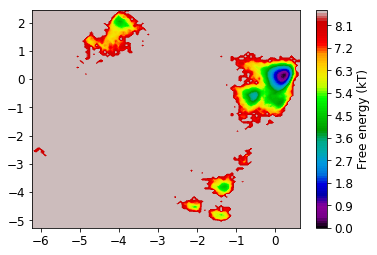

In [21]:
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1]);

Let's have a look how one of the trajectories looks like in the space of the first three TICA components. We can see that the TICA components nicely resolve the slow transitions as discrete jumps.

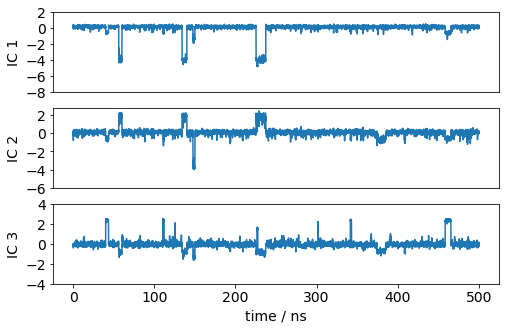

In [26]:
matplotlib.rcParams.update({'font.size': 14})
dt = 0.1
plt.figure(figsize=(8,5))
ax1=plt.subplot(311)
x = dt*np.arange(Y[0].shape[0])
plt.plot(x, Y[0][:,0]); plt.ylabel('IC 1'); plt.xticks([]); plt.yticks(np.arange(-8, 4, 2))
ax1=plt.subplot(312)
plt.plot(x, Y[0][:,1]); plt.ylabel('IC 2'); plt.xticks([]);  plt.yticks(np.arange(-6, 4, 2))
ax1=plt.subplot(313)
plt.plot(x, Y[0][:,2]); plt.xlabel('time / ns'); plt.ylabel('IC 3'); plt.yticks(np.arange(-4, 6, 2));

The TICA coordinates are now clustered into a number of discrete states using the k-means algorithm. The k-means algorithm requires as input the number of clusters *n_clusters*. For the metric there is only one choice possible here which is *euclidean*.

In [27]:
n_clusters = 250      # number of k-means clusters

In [28]:
clustering = coor.cluster_kmeans(Y,k=n_clusters)

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=250), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=10), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

15-02-18 14:33:44 pyemma.coordinates.clustering.kmeans.KmeansClustering[2] INFO     Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


The trajectories are now assigned to the cluster centers.

In [29]:
dtrajs = clustering.dtrajs

HBox(children=(HBox(children=(Label(value='getting output of KmeansClustering'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=25), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

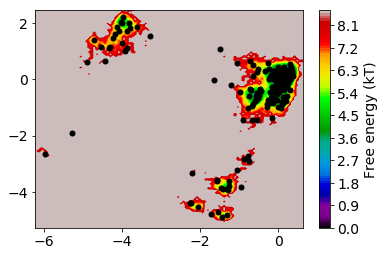

In [31]:
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1])
cc_x = clustering.clustercenters[:,0]
cc_y = clustering.clustercenters[:,1]
plt.plot(cc_x,cc_y, linewidth=0, marker='o', markersize=5, color='black')

The states are well distributed in phase space.

Implied timescales
-----

Here we calculate the implied timescales at a series of lagtimes defined in the *lags[ ]* array. Instead of an array you can just give a single number such as lags=100 in order to generate a range of lagtimes <= 100.

In [32]:
its = msm.timescales_msm(dtrajs, lags=200, nits=10)

HBox(children=(HBox(children=(Label(value='estimating MaximumLikelihoodMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=12), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

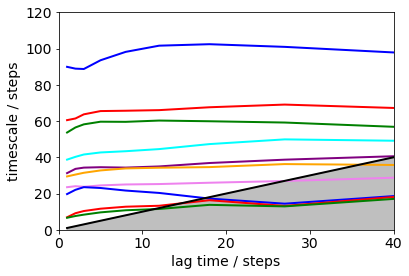

In [36]:
matplotlib.rcParams.update({'font.size': 14})
mplt.plot_implied_timescales(its, ylog=False, units='steps', linewidth=2)
plt.xlim(0, 40); plt.ylim(0, 120);

Error bars for the implied timescales can be obtained by bootstrapping.

In [37]:
its = msm.timescales_msm(dtrajs, lags=100, nits=10, errors='bayes', n_jobs=-1)

HBox(children=(HBox(children=(Label(value='estimating BayesianMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=11), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

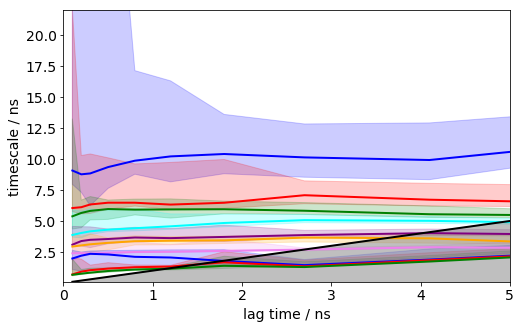

In [39]:
plt.figure(figsize=(8,5))
matplotlib.rcParams.update({'font.size': 14})
mplt.plot_implied_timescales(its, show_mean=False, ylog=False, dt=0.1, units='ns', linewidth=2)
plt.xlim(0, 5); plt.ylim(0.1,22);

It can be seen that the timescales are approximately constant within the error. Below we will select a lag time of 12 steps (1.2 ns) to build a Markov model.

Estimate MSM
-----

The lagtime to estimate the Markov model is specified as *msm_lag* here. 

In [40]:
msm_lag = 12
M = msm.estimate_markov_model(dtrajs, msm_lag)
print('fraction of states used = ', M.active_state_fraction)
print('fraction of counts used = ', M.active_count_fraction)

fraction of states used =  1.0
fraction of counts used =  1.0


In [41]:
# test MSM
M = msm.bayesian_markov_model(dtrajs, msm_lag)

HBox(children=(HBox(children=(Label(value='Sampling MSMs'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

In [42]:
ck = M.cktest(4, mlags=11, err_est=False)

HBox(children=(HBox(children=(Label(value='estimating BayesianMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=10), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

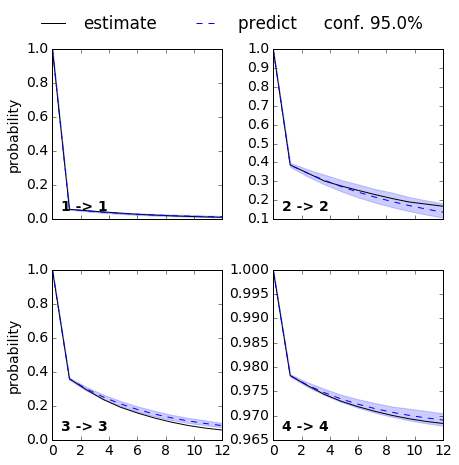

In [29]:
matplotlib.rcParams.update({'font.size': 14})
mplt.plot_cktest(ck, diag=True, figsize=(7,7), layout=(2,2), padding_top=0.1, y01=False, padding_between=0.3, dt=0.1, units='ns')

From the MSM which is now stored in the object we called *M* various properties can be obtained. We start by analyzing the free energy computed over the first two TICA coordinates

In [58]:
# ... therefore we take the statistical weight of each simulation timestep (also available from the MSM object)
# and use that to create a contour plot
xall = np.vstack(Y)[:,0]
yall = np.vstack(Y)[:,1]
W = np.concatenate(M.trajectory_weights())

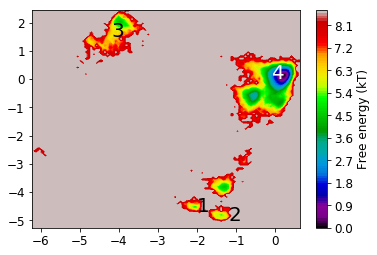

In [62]:
# TODO: make this an MSM-weighted free energy plot
matplotlib.rcParams.update({'font.size': 12})
mplt.plot_free_energy(xall, yall)
plot_labels()

Now we analyze the slowest processes by looking at the distribution of states along the first 3 eigenvectors.

In [63]:
# project eigenvectors
proj_ev_all = [np.hstack([M.eigenvectors_right()[:,i][dtraj] for dtraj in M.discrete_trajectories_full]) 
               for i in range(1, 10)]

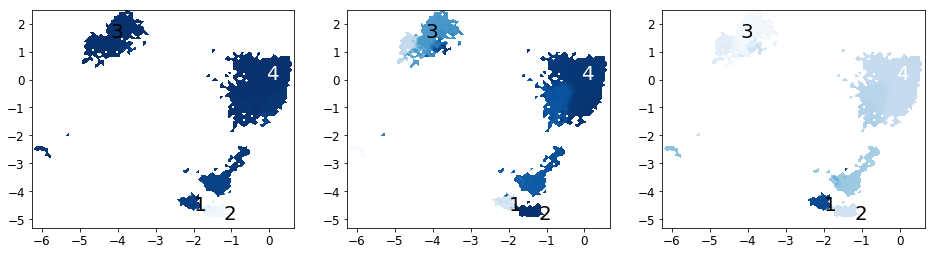

In [66]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
for i, ax in enumerate(axes):
    plot_sampled_function(xall, yall, proj_ev_all[i], ax=ax, cbar=False, cmap=plt.cm.Blues)
    plot_labels(ax)

PCCA
---

Next the MSM is coarse grained into a user-defined number of macrostates (*n_sets*).

In [67]:
n_sets = 4
M.pcca(n_sets)
pcca_dist = M.metastable_distributions
membership = M.metastable_memberships  # get PCCA memberships
# memberships over trajectory
dist_all = [np.hstack([pcca_dist[i,:][dtraj] for dtraj in M.discrete_trajectories_full]) for i in range(n_sets)]
mem_all = [np.hstack([membership[:,i][dtraj] for dtraj in M.discrete_trajectories_full]) for i in range(n_sets)]

We have now determined the probability for each microstate to belong to a given macrostate. These probabilities are called *memberships* to a given macrostate.

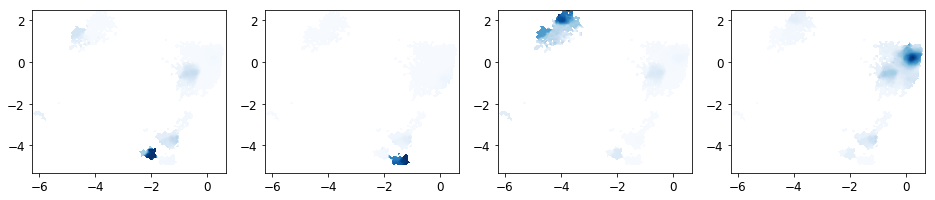

In [71]:
fig, axes = plt.subplots(1, 4, figsize=(16, 3))
matplotlib.rcParams.update({'font.size': 12})
axes = axes.flatten()

np.seterr(invalid='warn') 
for k in range(n_sets):
        plot_sampled_density(xall, yall, dist_all[k], ax=axes[k], cmap=plt.cm.Blues, cbar=False)

For each macrostate we can generate a number of representative sample structures and store them into a trajectory file.

In [72]:
pcca_samples = M.sample_by_distributions(pcca_dist, 10)

In [73]:
coor.save_trajs(inp, pcca_samples, outfiles=['./data/pcca1_10samples.xtc','./data/pcca2_10samples.xtc',
                                             './data/pcca3_10samples.xtc','./data/pcca4_10samples.xtc'])

['./data/pcca1_10samples.xtc',
 './data/pcca2_10samples.xtc',
 './data/pcca3_10samples.xtc',
 './data/pcca4_10samples.xtc']

Structure figures are generated with VMD, pyMol or another visualization program of your choice. Here we used VMD to generate the following structures, corresponding to the four metastable states shown at the end of the notebook

Coarse-grained kinetic Model using a Hidden Markov Model
------
Now we want a coarse-grained kinetic model between these four metastable states. Coarse-graining of Markov models has been investigated by a number of researchers, so different approaches exist. It is certainly a bad a idea to just bin the clusters into four groups, e.g. using the PCCA memberships, and then re-estimate an MSM on these four states. This is going to be a very poor MSM, most likely it will not get timescales anywhere near those seen above and fail the CK-Test.

We recomment the following approach: Use the MSM and the metastable states computed by PCCA in order to estimate a four-state HMM. This can be simply achieved by calling coarse-grain on the MSM:

In [74]:
hmm = M.coarse_grain(4)

15-02-18 15:34:19 pyemma.msm.estimators.bayesian_msm.BayesianMSM[8] WARNING  Requested coarse-grained model with 4 metastable states at lag=12. The ratio of relaxation timescales between 4 and 5 states is only 1.2981646871241692 while we recommend at least 1.5. It is possible that the resulting HMM is inaccurate. Handle with caution.


A HMM is also an MSM, just that it has a small (four-state) transition matrix, and equilibrium probabilities on four states:

In [75]:
hmm.stationary_distribution

array([ 0.0575265 ,  0.12146086,  0.02030485,  0.80070779])

In [76]:
hmm.transition_matrix

array([[ 0.80855296,  0.01797623,  0.00548975,  0.16798106],
       [ 0.00851393,  0.70638098,  0.00192846,  0.28317663],
       [ 0.01555324,  0.01153579,  0.83087514,  0.14203583],
       [ 0.01206853,  0.04295559,  0.00360183,  0.94137405]])

So let's visualize the HMM in a network plot. The numbers shown are transition probabilities given the model lag time (1.2 ns), which roughly correspond to rates per ns. It is seen that we have a star structure with one highly probably state as a hub, and a three less probable states that connect to it.

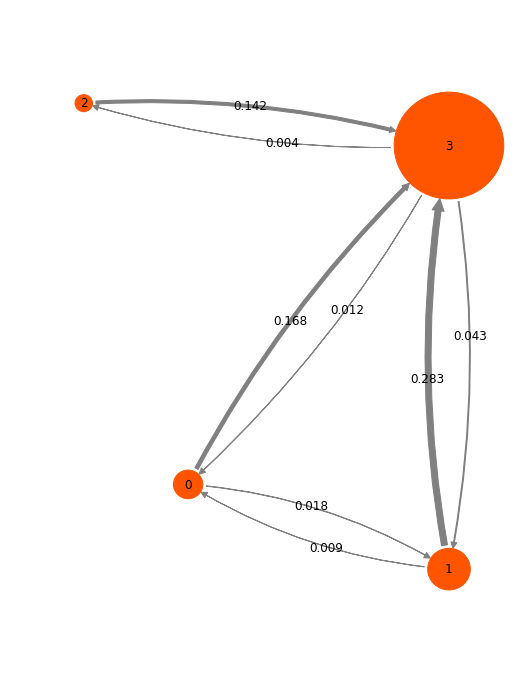

In [78]:
pos=np.array([[-3, -4], [0, -5], [-4.2, 0.5], [0, 0]])    
mplt.plot_markov_model(hmm, pos=pos, minflux=4e-4, arrow_label_format='%.3f')
plt.gca().set_frame_on(False)

Finally, we show the four metastable structures generated above:

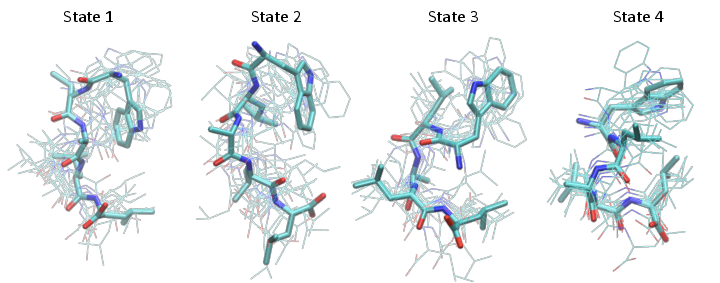

In [79]:
from IPython.display import Image
Image(filename='./data/pcca_structures.png', width=800)